In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
def fresnel_coeff(n1, n2, theta_i_deg):

    """
    s поляризация: вектор напряжённости электрического поля электромагнитной волны перпендикулярен плоскости падения.
    p поляризация: вектор напряжённости электрического поля лежит в плоскости падения.
    Rs, Rp: коэффициенты отражения для s и p поляризации
    Ts, Tp: коэффициенты пропускания для s и p поляризации 
    theta_i: угол падения.
    theta_t: угол преломления.
    """

    theta_i = np.deg2rad(theta_i_deg)
    sin_theta_i = np.sin(theta_i)

    total_reflection = False

    if n1 > n2 and sin_theta_i > (n2 / n1):
        total_reflection = True
        Rs = 1.0
        Rp = 1.0
        Ts = 0.0 
        Tp = 0.0

        theta_t_deg = np.nan
    else:
        sin_theta_t = n1/n2 * sin_theta_i
        theta_t = np.arcsin(np.clip(sin_theta_t, -1.0, 1.0))
        theta_t_deg = np.rad2deg(theta_t)

        # далее коэффициенты отражения
        cos_theta_i = np.cos(theta_i)
        cos_theta_t = np.cos(theta_t)

        Rs = ((n1 * cos_theta_i - n2 * cos_theta_t) / (n1 * cos_theta_i + n2 * cos_theta_t)) ** 2
        Rp = ((n2 * cos_theta_i - n1 * cos_theta_t) / (n2 * cos_theta_i + n1 * cos_theta_t)) ** 2

        Ts = 1 - Rs
        Tp = 1 - Rp
    
    return Rs, Rp, Ts, Tp, theta_t_deg, total_reflection


In [44]:
def plot_fresnel(n1, n2):
    if n1 == n2:
        brewster = 0.0
    else:
        brewster = np.rad2deg(np.arctan(n2 / n1))

    theta_i_deg = np.linspace(0, 90, 500)

    Rs = np.zeros_like(theta_i_deg)
    Rp = np.zeros_like(theta_i_deg)
    Ts = np.zeros_like(theta_i_deg)
    Tp = np.zeros_like(theta_i_deg)
    theta_t_deg = np.full_like(theta_i_deg, np.nan) 
    total_reflection = np.zeros_like(theta_i_deg, dtype=bool)

    for i, theta in enumerate(theta_i_deg):
        rs, rp, ts, tp, tt, tr = fresnel_coeff(n1, n2, theta)
        Rs[i] = rs
        Rp[i] = rp
        Ts[i] = ts
        Tp[i] = tp
        theta_t_deg[i] = tt
        total_reflection[i] = tr

    R_avg = (Rs+Rp)/2
    T_avg = (Ts+Tp)/2

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(0, 90)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)

    ax.set_xlabel("Угол падения")
    ax.set_ylabel("Коэффициент")
    ax.set_title(f"Коэффициенты Френеля")

    ax.plot(theta_i_deg, Tp, 'r-', linewidth=2.5, label=r'$T_p$')
    ax.plot(theta_i_deg, Ts, 'b-', linewidth=2.5, label=r'$T_s$')
    ax.plot(theta_i_deg, Rp, 'r--', linewidth=2.5, label=r'$R_p$')
    ax.plot(theta_i_deg, Rs, 'b--', linewidth=2.5, label=r'$R_s$')
    ax.plot(theta_i_deg, T_avg, 'k-', linewidth=2.5, label=r'$T_{\text{avg}} = (T_s + T_p)/2$')
    ax.plot(theta_i_deg, R_avg, 'k--', linewidth=2.5, label=r'$R_{\text{avg}} = (R_s + R_p)/2$')
    
    ax.axvline(brewster, linestyle='--', color='black', label=f'Угол Брюстера = {brewster:.1f}°')

    ax.legend()
    plt.tight_layout()
    plt.show()

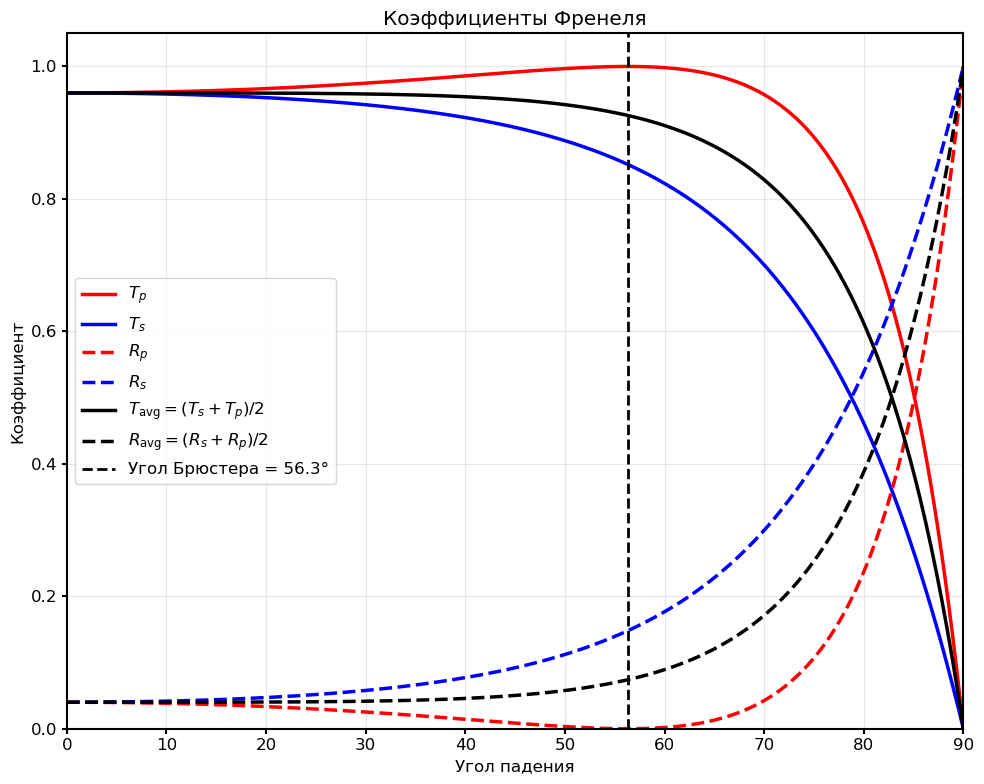

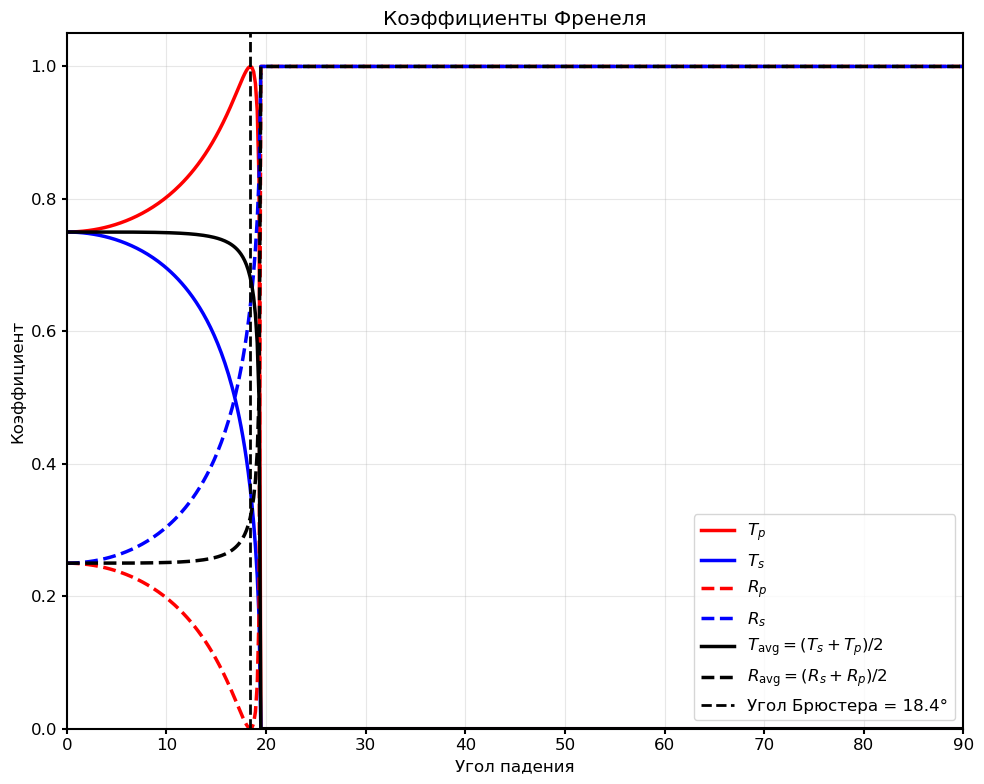

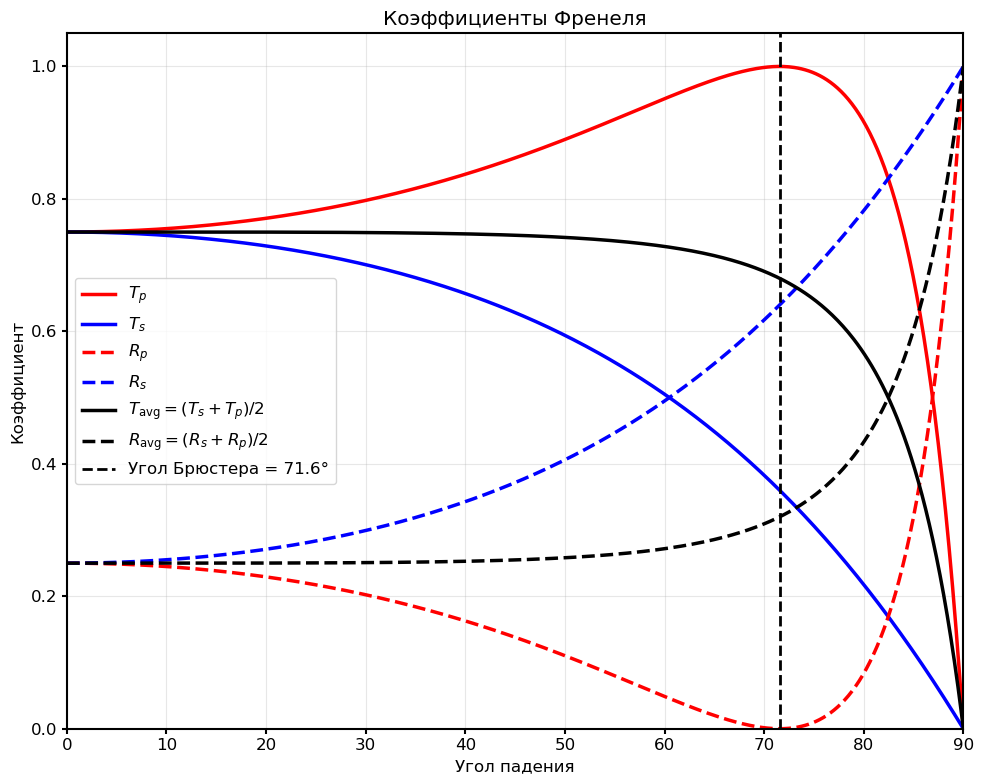

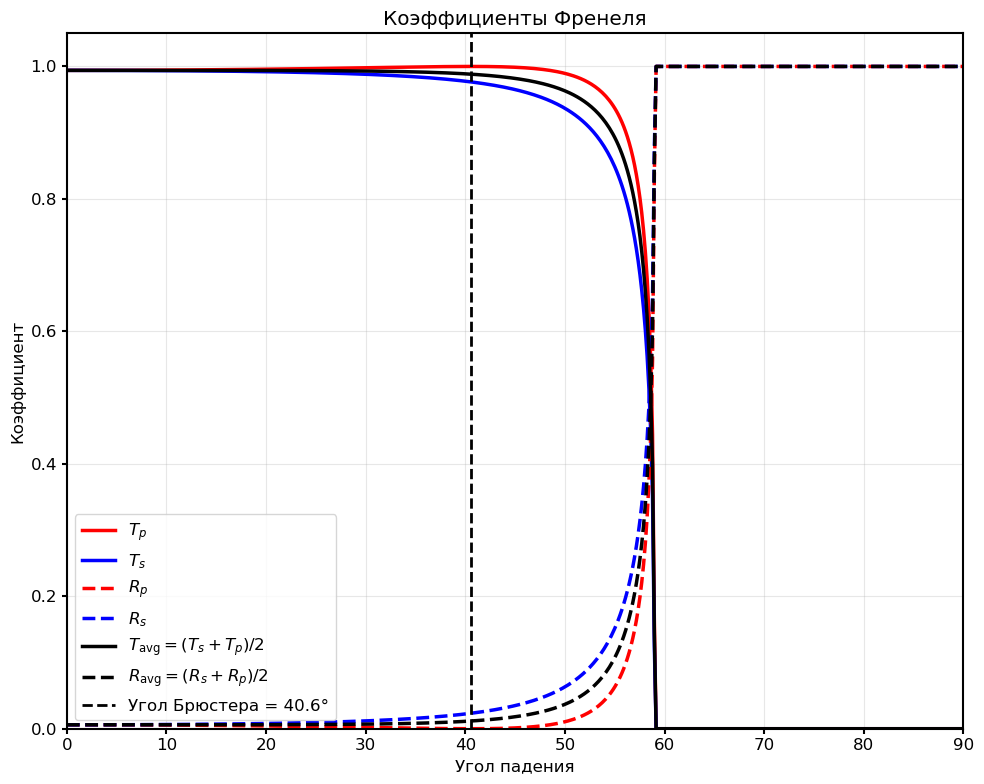

In [50]:
plot_fresnel(1, 1.5)
plot_fresnel(3, 1)
plot_fresnel(1, 3)
plot_fresnel(7, 6)

# Слоистая среда, состоящая из N слоёв.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fresnel_layers(n_list, k_list, d_list, wavelength):
    n_list = np.asarray(n_list, dtype=float) # Re часть комплексного показателя преломления
    k_list = np.asarray(k_list, dtype=float) # Im часть 
    d_list = np.asarray(d_list, dtype=float) # Толщина в метрах
    wavelength = np.asarray(wavelength, dtype=float) # Массив длин волн

    N_list = n_list - 1j * k_list
    R = np.zeros_like(wavelength, dtype=float)
    T = np.zeros_like(wavelength, dtype=float)

    for i, wl in enumerate(wavelength):
        M = np.eye(2, dtype=complex)  

        for j in range(1, len(N_list) - 1): # Обходим только покрытия между средой падения и подложкой
            N_j = N_list[j]
            d_j = d_list[j]
            delta = 2 * np.pi * N_j * d_j / wl # Фазовый набег при прохождении слоя волной

            cos_d = np.cos(delta)
            sin_d = np.sin(delta)
            gamma_j = N_j

            # Матрица переноса. Она связывает тангенциальные компоненты электромагнитного поля на входе слоя с теми же компонентами на его выходе.
            M_layer = np.array([                         
                [cos_d,            1j * sin_d / gamma_j],
                [1j * gamma_j * sin_d, cos_d           ]
            ], dtype=complex)

            M = M @ M_layer

        m11, m12 = M[0, 0], M[0, 1]
        m21, m22 = M[1, 0], M[1, 1]

        gamma0 = N_list[0]   
        gammaN = N_list[-1]  

        denom = (m11 + m12 * gammaN) * gamma0 + (m21 + m22 * gammaN)

        r = ((m11 + m12 * gammaN) * gamma0 - (m21 + m22 * gammaN)) / denom  # амплитудный коэффициент отражения
        t = (2 * gamma0) / denom # амплитудный коэффициент пропускания

        R[i] = np.abs(r) ** 2 #  коэффициент отражения по мощности R = |r|^2
        T[i] = np.real(gammaN / gamma0) * np.abs(t) ** 2 # коэффициент пропускания по мощности Re(gammaN / gamma 0)*|t|^2

        if T[i] < 0:
            T[i] = 0.0

    return R, T

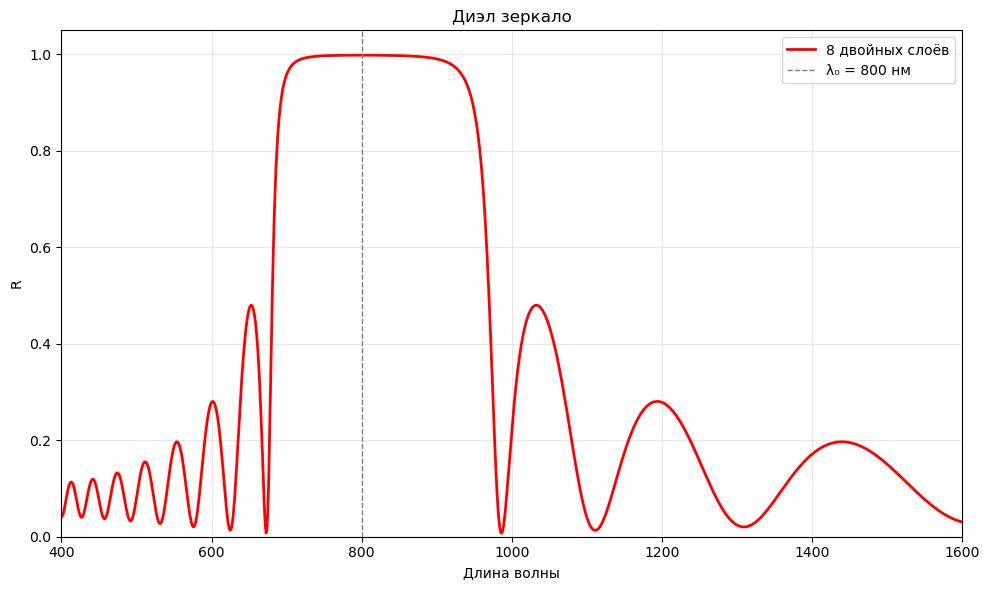

In [34]:
# wl_nm = np.linspace(400, 1200, 500)
# wl_m = wl_nm * 1e-9

# n_air = 1.0
# n_sub = 1.51  
# lambda0 = 800e-9  

# n_H = 2.2   #ZnS
# n_L = 1.38 # MgF2

# d_H = lambda0 / (4 * n_H) # толщина для ZnS
# d_L = lambda0 / (4 * n_L) # толщина для MgF2

# n1_list = [n_air, 1.38, 2.2, 1.38, n_sub] # Re часть комплексного показателя преломления
# k1_list = [0.0, 0.0, 0.0, 0.0, 0.0]  # Im часть коэфф поглощения
# d1_list = [0, lambda0 / (4 * 1.38), lambda0 / (4 * 2.2), lambda0 / (4 * 1.38), 0] # Толщина в метрах, d = lambda_0/4n

# R1, T1 = fresnel_layers(n1_list, k1_list, d1_list, wl_m)
# A1 = 1 - R1 - T1  # коэф поглощения, должно быть ≈ 0
# Сколько света отразилось (R),
# Сколько прошло (T),
# Сколько поглотилось (A)

wl_nm = np.linspace(400, 1600, 1000)
wl_m = wl_nm * 1e-9          # перевод в метры
lambda0 = 800e-9             # длина волны проектирования

n_air = 1.0
n_sub = 1.51                 
n_H = 2.2                    
n_L = 1.38                   


d_H = lambda0 / (4 * n_H)
d_L = lambda0 / (4 * n_L)
N_bilayers = 8

n_list = [n_air]                   
k_list = [0.0]

for _ in range(N_bilayers):
    n_list.extend([n_H, n_L])       
    k_list.extend([0.0, 0.0])        

n_list.append(n_sub)                 
k_list.append(0.0)

d_list = [0.0]
for _ in range(N_bilayers):
    d_list.extend([d_H, d_L])
d_list.append(0.0)

R, T = fresnel_layers(n_list, k_list, d_list, wl_m)

plt.figure(figsize=(10, 6))
plt.plot(wl_nm, R, color='red', linewidth=2, label=f'{N_bilayers} двойных слоёв')
plt.axvline(800, color='gray', linestyle='--', linewidth=1, label='λ₀ = 800 нм')

plt.xlim(400, 1600)
plt.ylim(0, 1.05)
plt.xlabel('Длина волны')
plt.ylabel('R')
plt.title('Диэл зеркало', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()